This notebooks serves as an example on how to run the model, by splitting the training into train and validation, and see how well it does on the validation set.

In [1]:
from utils_data import load_data,scale_props,get_graphs
from utils_plotting import plot_property_histograms
from sklearn.model_selection import train_test_split
from utils_model import train_and_validate_multi,get_preds_per_task,vals_to_df
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import AttentiveFP
import torch
import pandas as pd

In [2]:
train = pd.read_csv("train.csv")
train_graphs_DASH_charge_scaled = get_graphs(train,dash_charges=True,scaled =True,save_graphs = True)

Loading previously created graphs


In [3]:
outputs = 14 #keep this at 14 for now, this is all the properties for which graphs are made
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data, val_data = train_test_split(train_graphs_DASH_charge_scaled, test_size=0.2, random_state=2000)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
model= AttentiveFP(in_channels=24, hidden_channels=200, out_channels=outputs, #note that using the DASH graphs will increase the amount of node feauters (input channels for model) from 23 to 24
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3,
                        weight_decay=10**-4)
print(len(train_data), len(val_data))
train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs=100, outputs=outputs, verbose=True,props_to_train=['LogVP','LogP'],name='test_DASH_scaled')

14686 3672
Epoch 1/100: Train Loss: 0.1271, Val Loss: 0.0685
Epoch 2/100: Train Loss: 0.0663, Val Loss: 0.0668
Epoch 3/100: Train Loss: 0.0597, Val Loss: 0.0650
Epoch 4/100: Train Loss: 0.0579, Val Loss: 0.0595
Epoch 5/100: Train Loss: 0.0579, Val Loss: 0.0573
Epoch 6/100: Train Loss: 0.0557, Val Loss: 0.0635


In [ ]:
preds, ys = get_preds_per_task(model,val_loader, outputs,props_to_predict=['LogVP','LogP'])

2594


In [ ]:
df_preds = vals_to_df(preds,['LogVP','LogP'])
df_ys = vals_to_df(ys,['LogVP','LogP'])

Property: LogVP
kendall_tau: 0.78734176213245
rmse_overall: 1.4520745029074622
mae_overall: 1.033964572069633
within_03_overall: 0.19708029197080293
within_1_overall: 0.5961070559610706
R2: 0.8522949353777621
Pearson: 0.9239038275956961


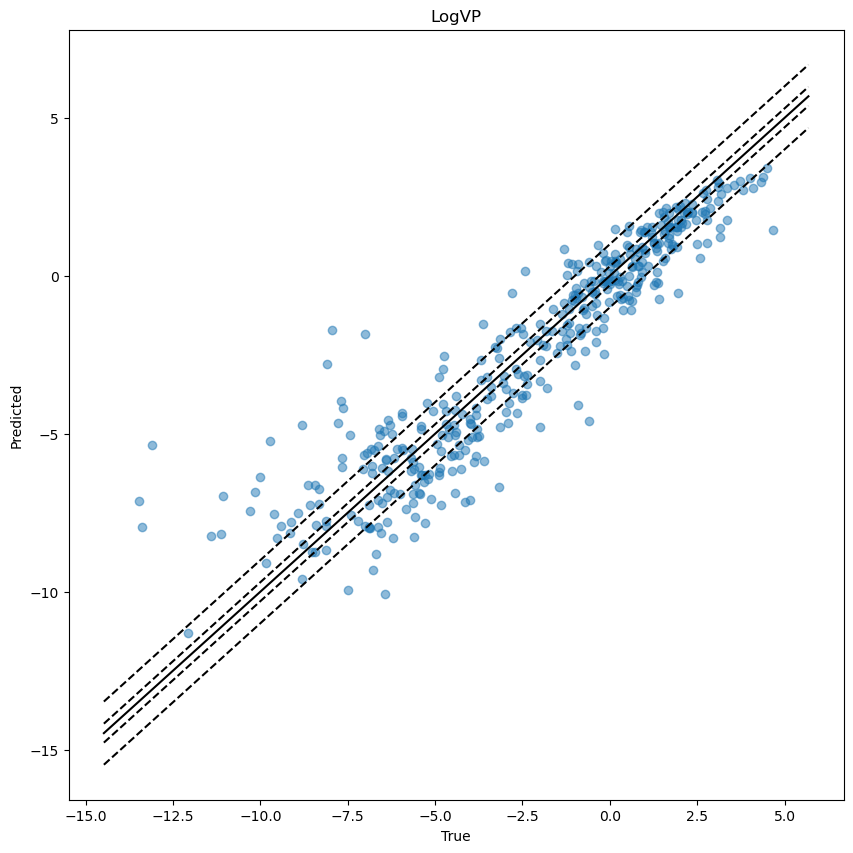

Property: LogP
kendall_tau: 0.7172808718040559
rmse_overall: 0.8602259327002122
mae_overall: 0.6581394232237524
within_03_overall: 0.2954649564819056
within_1_overall: 0.7906550618415025
R2: 0.7866809044978444
Pearson: 0.902609669532287


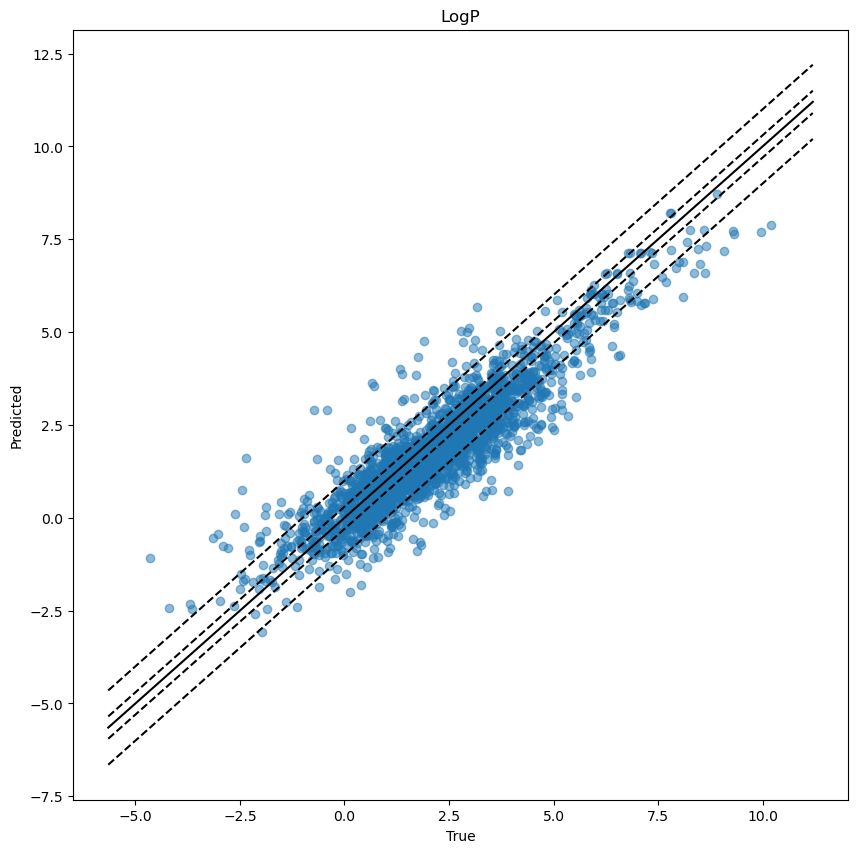

In [ ]:
#plot
from utils_plotting import plot_scatters
plot_scatters(df_preds,df_ys)

In [ ]:
#compare to using the unscaled DASH charges
train_graphs_DASH_charge_unscaled = get_graphs(train,dash_charges=True,scaled =False,save_graphs = True)
train_data, val_data = train_test_split(train_graphs_DASH_charge_unscaled, test_size=0.2, random_state=2000)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
model= AttentiveFP(in_channels=24, hidden_channels=200, out_channels=outputs, #note that using the DASH graphs will increase the amount of node feauters (input channels for model) from 23 to 24
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3,
                        weight_decay=10**-4)
print(len(train_data), len(val_data))
train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs=100, outputs=outputs, verbose=True,props_to_train=['LogVP','LogP'],name='test_DASH_unscaled')

In [ ]:
preds, ys = get_preds_per_task(model,val_loader, outputs,props_to_predict=['LogVP','LogP'])
df_preds = vals_to_df(preds,['LogVP','LogP'],scaled=False)
df_ys = vals_to_df(ys,['LogVP','LogP'],scaled=False)
plot_scatters(df_preds,df_ys)

To do:
1. Add the different endpoints - check
2. Normalization of values
3. Weighting of the tasks
4. Hyperparameter optimization
5. Benchmarking datasets? E.g. SAMPL7 for logP
6. Quadruple check refs - check
7. Think about datasplitting: same splits as OPERA? possible? otherwise, just cross-val? or random splits (multiple)
8. Different random weight initializations of the model


split: 80/20 5x

HP OPT: https://docs.ray.io/en/latest/tune/api/doc/ray.tune.search.bayesopt.BayesOptSearch.html
Repeated K-fold: https://greglandrum.github.io/rdkit-blog/posts/2023-08-13-xval-variability1.html